<a href="https://colab.research.google.com/github/gersonAsifiwe/AutoEncoder/blob/main/Copy_of_6_390_Homework08_Fall23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RUN THIS NOTEBOOK WITH GPU**

OTHERWISE YOU WILL SPEND A LONG TIME ON TRAINING

**To do this, go to `Runtime` > `Change runtime type` and under `hardware acceleration` set the dropdown to `GPU`.**

## Building an Autoencoder

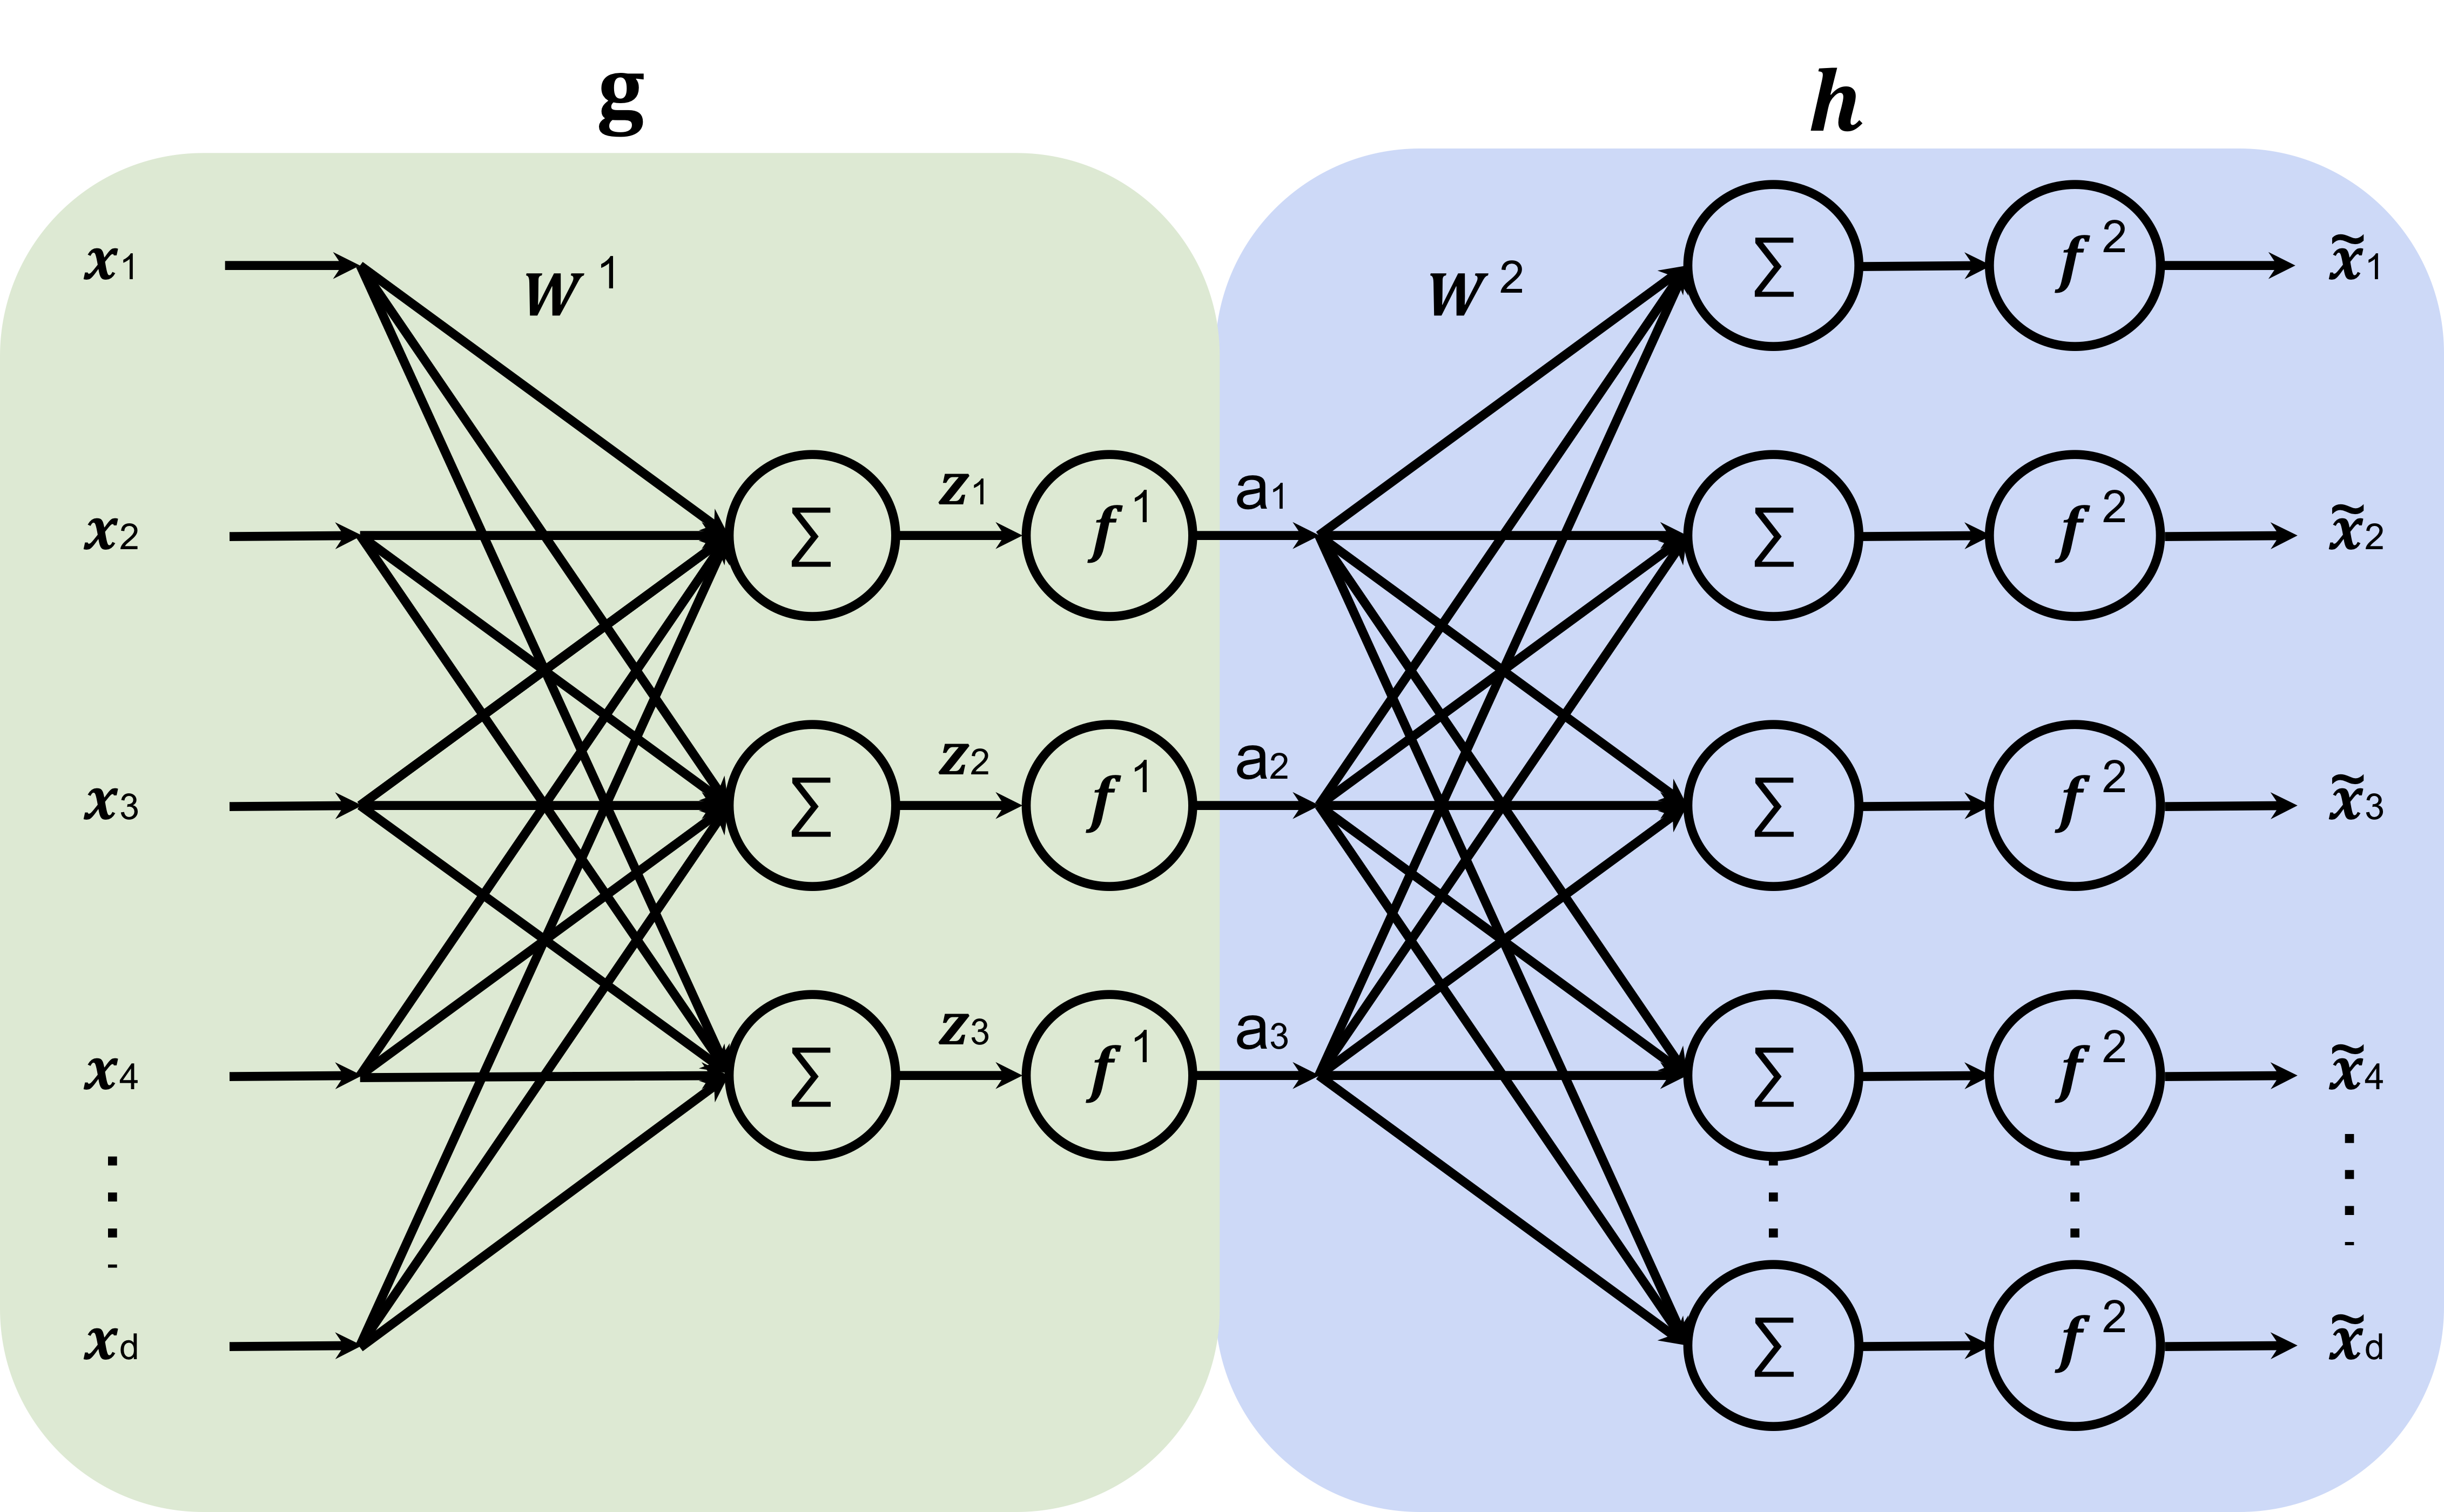

## Boilerplate

Run the following cells to load the data.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

# To get the MNIST (digit images) dataset
from keras.datasets import mnist

torch.manual_seed(0)

In [ ]:
# Download MNIST Data
(mnist_train, labels_train), (mnist_test, labels_test) = mnist.load_data()

# Load data as Numpy arrays of size (#datapoints, 28*28=784)
mnist_train = mnist_train.astype('float32') / 255.
mnist_test = mnist_test.astype('float32') / 255.
mnist_train = mnist_train.reshape((len(mnist_train), np.prod(mnist_train.shape[1:])))
mnist_test = mnist_test.reshape((len(mnist_test), np.prod(mnist_test.shape[1:])))

# Split test data into a test and validation set:
val_data = mnist_test[:(mnist_test.shape[0]//2),:]
test_data = mnist_test[(mnist_test.shape[0]//2):,:]
train_data = mnist_train

val_labels = labels_test[:(mnist_test.shape[0]//2)]
test_labels = labels_test[(mnist_test.shape[0]//2):]
train_labels = labels_train

# Display dataset information
print("Downloaded the following data:")
print(f"train_data has shape {train_data.shape}, containing {train_data.shape[0]} images represented as ({train_data.shape[1]}, 1) vectors")
print(f"val_data has shape {val_data.shape}, containing {val_data.shape[0]} images represented as ({val_data.shape[1]}, 1) vectors")
print(f"train_data has shape {test_data.shape}, containing {test_data.shape[0]} images represented as ({test_data.shape[1]}, 1) vectors")

11490434/11490434 [==============================] - 2s 0us/step
Downloaded the following data:
train_data has shape (60000, 784), containing 60000 images represented as (784, 1) vectors
val_data has shape (5000, 784), containing 5000 images represented as (784, 1) vectors
train_data has shape (5000, 784), containing 5000 images represented as (784, 1) vectors


In [ ]:
# Create a Dataset class to use with PyTorch's Built-In Dataloaders
class MNISTDataset(Dataset):
    '''
    A custom dataset class to use with PyTorch's built-in dataloaders.
    This will make feeding images to our models much easier downstream.

    data: np.arrays downloaded from Keras' databases
    vectorize: if True, outputed image data will be (784,)
                   if False, outputed image data will be (28,28)
    '''
    def __init__(self, data, labels, vectorize=True):
        self.data = data
        self.labels = labels
        self.vectorize = vectorize

    def __getitem__(self, idx):
        image_data = self.data[idx, :]
        image_data = image_data.reshape((1,28,28))
        if self.vectorize:
            image_data = image_data.reshape((784,))
        image_label = self.labels[idx]
        return image_data, image_label

    def __len__(self):
        return self.data.shape[0]

# Create MNISTDataset objects for each of our train/val/test sets
train_dataset = MNISTDataset(train_data, train_labels)
val_dataset = MNISTDataset(val_data, val_labels)
test_dataset = MNISTDataset(test_data, test_labels)

# Create a PyTorch dataloader for each train/val/test set
# We'll use a batch size of 256 for the rest of this assignment.
train_loader = DataLoader(train_dataset, batch_size=256)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

# Display dataloader info
print("Created the following Dataloaders:")
print(f"train_loader has {len(train_loader)} batches of training data")
print(f"val_loader has {len(val_loader)} batches of validation data")
print(f"test_loader has {len(test_loader)} batches of testing data")

Created the following Dataloaders:
train_loader has 235 batches of training data
val_loader has 20 batches of validation data
test_loader has 20 batches of testing data


## A Simple (One-Layer) Autoencoder

### Architecture Implementation
The architecture will have the following characteristics:

* Each (28x28) image will be reshaped into a (784,) column vector to input
* Use a batch size of 256. That is, we'll feed in 256 images to our autoencoder at a time, and use batch gradient descent during training.
* Use a representation size of 32 (i.e. the size of the representation outputted by the encoder is 32).

* The encoder uses a single fully-connected layer with ReLU activation.
* The decoder uses a single fully-connected layer with Linear activation.
* The size of the image outputted by the decoder should be 784, to match the size of our input images. Combined with our batch size, the tensor output by the autoencoder for each input batch should have dimension [256, 784].
* Use the element-wise mean squared error between the output of our autoencoder and our input image.


In [ ]:
class SimpleAutoEncoder(nn.Module):
    '''
    An autoencoder with a single fully-connected layer for the encoder, and a
    single fully-connected layer for the decoder.

    representation_size: integer reprsenting the size of the learned representation.
                         Also known as the encoding or embedding dimension.
                         This is also the size of the output of the encoder.

    input_size: integer representing the size of each input column vector.
                In this assignment, this will end up being 784.
    '''
    def __init__(self, representation_size, input_size=784):
        '''
        This is where all the modules that make up our simple autoencoder get stored.

        self.encoder_preactivation implements the fully-connected layer (without activation yet)
        self.encoder_activation implements the encoder's activation function
        self.decoder-preactivation implements the decoder's fully-connected layer.

        '''
        super(SimpleAutoEncoder, self).__init__()
        self.representation_size = representation_size
        self.input_size = input_size
        self.encoder_preactivation = nn.Linear(input_size,representation_size)
        self.encoder_activation = nn.ReLU()
        self.decoder_preactivation = nn.Linear(representation_size,input_size)

    def encode(self, x):
        '''
        Runs the encoder of the network. Implement this function to define how the
        encoder should process and input x, which implicitly sets how the encoder
        modules saved in __init__() should be chained together

        x: a single batch of input data
        '''
        preactivation = self.encoder_preactivation(x)
        activation = self.encoder_activation(preactivation)
        return activation

    def decode(self, a):
        '''
        Runs the encoder of the network. Implement this function to define how the
        decoder should process a latent representation (output of the encoder) a,
        which implicitly sets how the decoder modules saved in __init__() should be chained together

        a: the output of encode(x)
        '''
        preactivation = self.decoder_preactivation(a)
        return preactivation

    def forward(self, x):
        '''
        The forward pass defines how to process an input x. This implicitly sets how
        the modules saved in __init__() should be chained together.

        Every PyTorch module has a forward() function, and when defining our own
        modules like we're doing here, we're required to define its forward().
        Here, we'll use the encode() and decode() functions to define forward().

        x: a single batch of input data
        '''
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime

### Implement train() and test()

Now implement the functions to `train` and `test` our autoencoder using element-wise mean squared error between the output of our autoencoder and our input image.


In [1]:
def train(model, device, train_loader, optimizer, val_loader=None):
    '''
    Function for training our networks. One call to train() performs a single
    epoch for training.

    model: an instance of our model, this will be the autoencoder

    device: either "cpu" or "cuda", depending on if you're running with GPU support

    train_loader: the dataloader for the training set

    optimizer: optimizer used for training (the optimizer implements SGD)

    val_loader: (optional) validation set to include
    '''

    # Set the model to training mode.
    model.train()

    #we'll keep adding the loss of each batch to total_loss, so we can calculate
    #the average loss at the end of the epoch.
    total_loss = 0

    # We'll iterate through each batch. One call of train() trains for 1 epoch.
    # batch_idx: an integer representing which batch number we're on
    # input: a pytorch tensor representing a batch of input images.
    for batch_idx, (input, _) in enumerate(train_loader):
        # This line sends data to GPU if you're using a GPU
        input = input.to(device)

        # Zero out gradients from previous iteration
        optimizer.zero_grad()

        # feed our input through the network
        output = model.forward(input)

        ## loss

        loss_function = nn.MSELoss()
        loss_value = loss_function(input,output)

        # Perform backprop
        loss_value.backward()
        optimizer.step()

        #accumulate loss to later calculate the average
        total_loss += loss_value

    return total_loss.item()/len(train_loader)

In [ ]:
def test(model, device, test_loader):
    '''
    Function for testing our models. One call to test() runs through every
    datapoint in our dataset once.

    model: an instance of our model, in this assignment, this will be the autoencoder

    device: either "cpu" or "cuda:0", depending on if you're running with GPU support

    test_loader: the dataloader for the data to run the model on
    '''
    # set model to evaluation mode
    model.eval()

    # we'll keep track of total loss to calculate the average later
    test_loss = 0

    # don’t track gradients in testing, since no backprop
    with torch.no_grad():
        # iterate through each test image
        for input, _ in test_loader:

            # send input image to GPU if using GPU
            input = input.to(device)

            # run input through our model
            output = model(input)

            # loss
            loss_function = nn.MSELoss()
            test_loss += loss_function(input,output)

    # calculate average loss per batch
    test_loss /= len(test_loader)
    return test_loss.item()

Run the following blocks of code to train and test the autoencoder.

*Note: This cell may take a minute or two to run.*

In [ ]:
# RUN ME!

# Set representation size
representation_size = 32

# Train for 50 epochs.
epochs = 50

# check if running on CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize a simple autoencoder
simple_autoencoder = SimpleAutoEncoder(representation_size).to(device)

# We'll use the Adam optimization of gradient descent.
optimizer = torch.optim.Adam(simple_autoencoder.parameters())

# Train the autoencoder
for epoch in range(1, epochs+1):
    train_loss = train(simple_autoencoder, device, train_loader, optimizer)
    val_loss = test(simple_autoencoder, device, val_loader)
    print('Train Epoch: {:02d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

# Test your autoencoder
print('Test Loss:', test(simple_autoencoder, device, test_loader))

Train Epoch: 01 	Training Loss: 0.063162 	Validation Loss: 0.043441
Train Epoch: 02 	Training Loss: 0.038762 	Validation Loss: 0.034853
Train Epoch: 03 	Training Loss: 0.032971 	Validation Loss: 0.031132
Train Epoch: 04 	Training Loss: 0.030162 	Validation Loss: 0.029295
Train Epoch: 05 	Training Loss: 0.028771 	Validation Loss: 0.027918
Train Epoch: 06 	Training Loss: 0.027400 	Validation Loss: 0.027187
Train Epoch: 07 	Training Loss: 0.027026 	Validation Loss: 0.026960
Train Epoch: 08 	Training Loss: 0.026881 	Validation Loss: 0.026835
Train Epoch: 09 	Training Loss: 0.026791 	Validation Loss: 0.026750
Train Epoch: 10 	Training Loss: 0.026742 	Validation Loss: 0.026688
Train Epoch: 11 	Training Loss: 0.026679 	Validation Loss: 0.026637
Train Epoch: 12 	Training Loss: 0.026643 	Validation Loss: 0.026606
Train Epoch: 13 	Training Loss: 0.026619 	Validation Loss: 0.026591
Train Epoch: 14 	Training Loss: 0.026609 	Validation Loss: 0.026576
Train Epoch: 15 	Training Loss: 0.026582 	Valida

Visualize the outputs of the trained autoencoder!

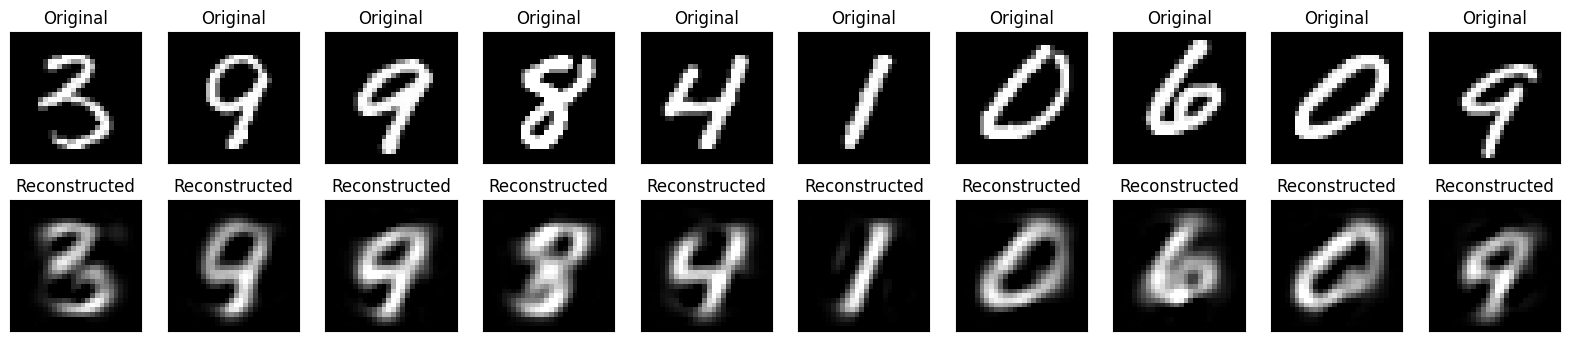

In [ ]:
# RUN ME! No changes necessary.

# Encode and decode some digits
# Note that we take them from the *test* set
x_test = torch.tensor(test_dataset.data).to(device)
encoded_imgs = simple_autoencoder.encode(x_test.float())
decoded_imgs = simple_autoencoder.decode(encoded_imgs).cpu().detach().numpy()

# Display the original and encoded images
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title('Original')
    plt.imshow(x_test[i].reshape(28, 28).cpu())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title('Reconstructed')
    plt.imshow(np.clip( decoded_imgs[i].reshape(28, 28), 0., 1.) )
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## A Deep (Multi-Layer) Autoencoder

* Each (28x28) image will be reshaped into a (784,) column vector to input
* Use a batch size of 256. That is, we'll feed in 256 images to our autoencoder at a time, and use batch gradient descent during training.
* Before transforming the input directly to the representation space, we'll first use a layer to "compress" the input to a size of 200.
* Use a representation size of 32 (i.e. the size of the representation outputted by the encoder is 32).
* The decoder will also first transform the representation from a size of 32 to a size of 200, before completing the decoding.

Note:

* The encoder uses two fully-connected layers, each with ReLU activations.
* The decoder uses two fully-connected layers; the first with ReLU activation and the second with Linear activation.
* The size of the image outputted by the decoder should be 784, to match the size of our input images. Combined with our batch size, the tensor output by the autoencoder for each input batch should have dimension [256, 784].
* The train() and test() methods are the same that are used for the SimpleAutoEncoder.

In [ ]:
class DeepAutoEncoder(nn.Module):
    '''
    An autoencoder with two fully-connected layer for the encoder, and two
    fully-connected layer for the decoder.

    compress: number of units in hidden layer of encoder and decoder

    representation_size: integer reprsenting the size of the learned representation.
                         Also known as the encoding or embedding dimension.
                         This is also the size of the output of the encoder.

    input_size: integer representing the size of each input column vector.
                In this assignment, this will end up being 784.
    '''
    def __init__(self, compress, representation_size, input_size=784):
        '''
        This is where all the modules that make up our deep autoencoder get stored.

        self.encoder_preactivation_1 should implement the first fully-connected layer (without activation yet)
        self.encoder_activation_1 should implement the activation function of the encoder's first layer
        self.encoder_preactivation_2 and self.activation_2 mirror those of the first encoder layer

        self.decoder_preactivation_1 should implement the decoder's first fully-connected layer
        self.decoder_activation_1 should implement the activation function of the decoder's first layer
        self.decoder_preactivation_2 should implement the decoder's second fully-connected layer

        '''
        super(DeepAutoEncoder, self).__init__()
        self.representation_size = representation_size
        self.compress = compress
        self.input_size = input_size

        ## First layer of encoder
        self.encoder_preactivation_1 = nn.Linear(input_size,200)
        self.encoder_activation_1 = nn.ReLU()
        ## Second layer of encoder
        self.encoder_preactivation_2 =nn.Linear(200,representation_size)
        self.encoder_activation_2 = nn.ReLU()
        ## First layer of decoder
        self.decoder_preactivation_1 = nn.Linear(representation_size,200)
        self.decoder_activation_1 = nn.ReLU()
        ## Second layer of decoder
        self.decoder_preactivation_2 = nn.Linear(200,input_size)

    def encode(self, x):
        '''
        Runs the encoder of the network. Implement this function to define how the
        encoder should process and input x, which implicitly sets how the encoder
        modules saved in __init__() should be chained together

        x: a single batch of input data
        '''
        a1 = self.encoder_activation_1(self.encoder_preactivation_1(x))
        a2 = self.encoder_activation_2(self.encoder_preactivation_2(a1))
        return a2
    def decode(self, a):
        '''
        Runs the encoder of the network. Implement this function to define how the
        decoder should process a latent representation (output of the encoder) a,
        which implicitly sets how the decoder modules saved in __init__() should be chained together

        a: the output of encode(x)
        '''
        a3 = self.decoder_activation_1(self.decoder_preactivation_1(a))
        a4 = self.decoder_preactivation_2(a3)
        return a4

    def forward(self, x):
        '''
        The forward pass defines how to process an input x. This implicitly sets how
        the modules saved in __init__() should be chained together.

        Every PyTorch module has a forward() function, and when defining our own
        modules like we're doing here, we're required to define its forward().
        Here, we'll use your encode() and decode() functions to define forward().

        x: a single batch of input data
        '''
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime

Run the following blocks of code to train and test the autoencoder.


In [ ]:
# RUN ME! No changes necessary.

# Set compress size
compress = 200

# Set representation size
representation_size = 32

# Train for 50 epochs.
epochs = 50

# check if running on CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize a simple autoencoder
deep_autoencoder = DeepAutoEncoder(compress, representation_size).to(device)

# We'll use the Adam optimization of gradient descent.
optimizer = torch.optim.Adam(deep_autoencoder.parameters())

# Train the autoencoder
for epoch in range(1, epochs+1):
    train_loss = train(deep_autoencoder, device, train_loader, optimizer)
    val_loss = test(deep_autoencoder, device, val_loader)
    print('Train Epoch: {:02d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

# Test the autoencoder
print('\nReport this number on the course website:')
print('Test Loss:', test(deep_autoencoder, device, test_loader))

Train Epoch: 01 	Training Loss: 0.039936 	Validation Loss: 0.025523
Train Epoch: 02 	Training Loss: 0.022987 	Validation Loss: 0.021973
Train Epoch: 03 	Training Loss: 0.020909 	Validation Loss: 0.020511
Train Epoch: 04 	Training Loss: 0.019835 	Validation Loss: 0.019605
Train Epoch: 05 	Training Loss: 0.019090 	Validation Loss: 0.018990
Train Epoch: 06 	Training Loss: 0.018477 	Validation Loss: 0.018452
Train Epoch: 07 	Training Loss: 0.017990 	Validation Loss: 0.017994
Train Epoch: 08 	Training Loss: 0.017594 	Validation Loss: 0.017547
Train Epoch: 09 	Training Loss: 0.017245 	Validation Loss: 0.017221
Train Epoch: 10 	Training Loss: 0.016934 	Validation Loss: 0.016961
Train Epoch: 11 	Training Loss: 0.016665 	Validation Loss: 0.016722
Train Epoch: 12 	Training Loss: 0.016419 	Validation Loss: 0.016480
Train Epoch: 13 	Training Loss: 0.016190 	Validation Loss: 0.016248
Train Epoch: 14 	Training Loss: 0.015987 	Validation Loss: 0.016023
Train Epoch: 15 	Training Loss: 0.015802 	Valida

... and visualize!

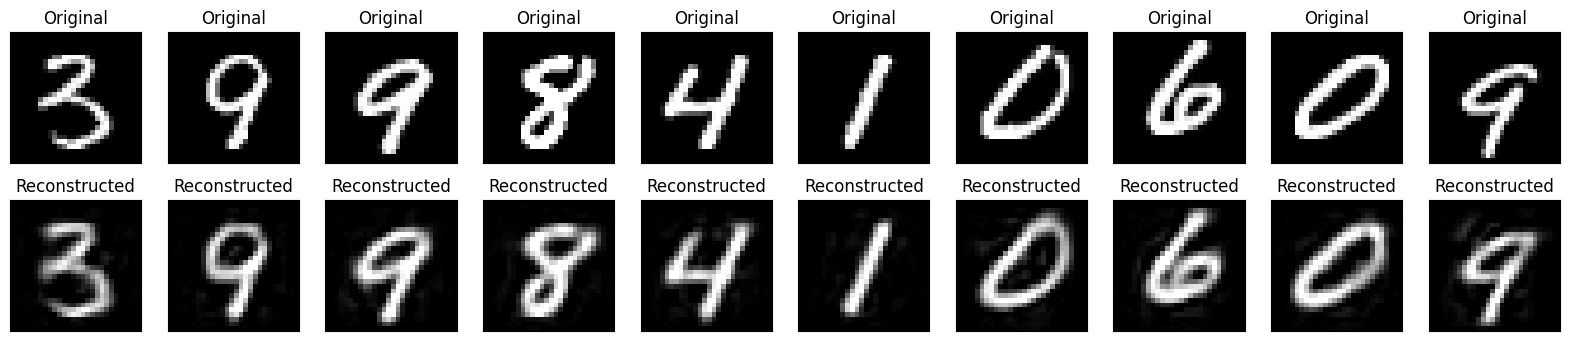

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
x_test = torch.tensor(test_dataset.data).to(device)
encoded_imgs = deep_autoencoder.encode(x_test.float())
decoded_imgs = deep_autoencoder.decode(encoded_imgs).cpu().detach().numpy()

# Display the original and encoded images
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title('Original')
    plt.imshow(x_test[i].reshape(28, 28).cpu())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title('Reconstructed')
    plt.imshow(np.clip( decoded_imgs[i].reshape(28, 28), 0., 1.) )
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising Images with AutoEncoders

The train and test functions that will train and test a model using the new setup described above.


In [ ]:

def train_denoiser(model, device, train_loader, optimizer):
    '''
    Function for training our networks on noisy data.
    One call to train() performs a single epoch of training.

    model: an instance of our model, in this assignment, this will be the autoencoder

    device: either "cpu:0" or "gpu", depending on if you're running with GPU support

    train_loader: the dataloader for the training set

    optimizer: optimizer used for training (the optimizer implements SGD)

    val_loader: (optional) validation set to include
    '''
    # Set the model to training mode.
    model.train()

    # we'll keep adding the loss of each batch to total_loss, so we can calculate
    # the average loss at the end of the epoch.
    total_loss = 0

    # We'll iterate through each batch. One call of train() trains for 1 epoch.
    # batch_idx: an integer representing which batch number we're on
    # noisy: a pytorch tensor representing the noisy image to input
    # clean: a pytorch tensor representing the noise-less version of our input
    for batch_idx, (noisy, clean) in enumerate(train_loader):
        # This line sends data to GPU if you're using a GPU
        noisy = noisy.to(device, dtype=torch.float)
        clean = clean.to(device, dtype=torch.float)

        # Zero out gradients from previous iteration
        optimizer.zero_grad()

        # feed our input through the network
        output = model.forward(noisy)

        # calculate the loss
        loss_function = nn.MSELoss()
        loss_value = loss_function(output,clean)

        # Perform backprop
        loss_value.backward()
        optimizer.step()

        #accumulate loss to later calculate the average
        total_loss += loss_value

    return total_loss.item()/len(train_loader)


In [ ]:
def test_denoiser(model, device, test_loader):
    '''
    Function for testing our models on noisy data.
    One call to test() runs through every datapoint in our dataset once.

    model: an instance of our model, in this assignment, this will be the autoencoder

    device: either "cpu:0" or "gpu", depending on if you're running with GPU support

    test_loader: the dataloader for the data to run the model on
    '''
    # set model to evaluation mode
    model.eval()

    # we'll keep track of total loss to calculate the average later
    test_loss = 0

    # don’t track gradients in testing, since no backprop
    with torch.no_grad():

        # iterate thorugh each test image
        # noisy: a pytorch tensor representing the noisy image to input
        # clean: a pytorch tensor representing the noise-less version of our input
        for noisy, clean in test_loader:

            # send images to GPU if using GPU
            noisy = noisy.to(device, dtype=torch.float)
            clean = clean.to(device, dtype=torch.float)

            # run input through our model
            output = model(noisy)

            # calculate loss
            loss_function = nn.MSELoss()
            test_loss += loss_function(output,clean)

    # calculate average loss per batch
    test_loss /= len(test_loader)
    return test_loss.item()

Now that new `train_denoiser()` and `test_denoiser()` functions are complete, let's use them to denoise some images! Run the following boxes to train a CNN autoencoder to de-noise digit images.

In [ ]:
# Construct a dataset and dataloader of images with white noise overlaid
class NoisyMNISTDataset(Dataset):
    '''
    A custom dataset class to use with PyTorch's built-in dataloaders.
    This will make feeding images to our models much easier downstream.

    data: np.arrays downloaded from Keras' databases
    vectorize: if True, outputed image data will be (784,)
                   if False, outputed image data will be (28,28)
    '''
    def __init__(self, data, noise_factor=0.3, vectorize=False):
        self.noisy_data = np.clip(data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape), 0., 1.)
        self.clean_data = data
        self.vectorize = vectorize
        self.noise_factor = noise_factor

    def __getitem__(self, idx):
        clean_image_data = self.clean_data[idx, :].reshape((1,28,28))
        noisy_image_data = self.noisy_data[idx, :].reshape((1,28,28))
        if self.vectorize:
            clean_image_data = clean_image_data.reshape((784,))
            noisy_image_data = noisy_image_data.reshape((784,))
        return noisy_image_data, clean_image_data

    def __len__(self):
        return self.clean_data.shape[0]

noise_factor = 0.3
noisy_train_dataset = NoisyMNISTDataset(train_data, noise_factor=noise_factor, vectorize=True)
noisy_val_dataset = NoisyMNISTDataset(val_data, noise_factor=noise_factor, vectorize=True)
noisy_test_dataset = NoisyMNISTDataset(test_data, noise_factor=noise_factor, vectorize=True)

noisy_train_loader = DataLoader(noisy_train_dataset, batch_size=256)
noisy_val_loader = DataLoader(noisy_val_dataset, batch_size=256)
noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=256)


## Denoising with the SimpleAutoEncoder

In [ ]:

# NOTE: Rerun this block if you want to use SimpleAutoEncoder
#       again after using the DeepAutoEncoder

# Train a SimpleAutoEncoder for denoising.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
denoising_autoencoder = SimpleAutoEncoder(32).to(device)

optimizer = torch.optim.Adam(denoising_autoencoder.parameters())
epochs = 50

# Train your autoencoder
for epoch in range(1, epochs+1):
    train_loss = train_denoiser(denoising_autoencoder, device, noisy_train_loader, optimizer)
    val_loss = test_denoiser(denoising_autoencoder, device, noisy_val_loader, )
    print('Train Epoch: {:02d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

# Test your autoencoder
print('Test Loss:', test_denoiser(denoising_autoencoder, device, noisy_test_loader))

Train Epoch: 01 	Training Loss: 0.074449 	Validation Loss: 0.057304
Train Epoch: 02 	Training Loss: 0.057194 	Validation Loss: 0.052706
Train Epoch: 03 	Training Loss: 0.052055 	Validation Loss: 0.048707
Train Epoch: 04 	Training Loss: 0.049727 	Validation Loss: 0.047981
Train Epoch: 05 	Training Loss: 0.049311 	Validation Loss: 0.047800
Train Epoch: 06 	Training Loss: 0.049155 	Validation Loss: 0.047697
Train Epoch: 07 	Training Loss: 0.049057 	Validation Loss: 0.047629
Train Epoch: 08 	Training Loss: 0.048989 	Validation Loss: 0.047583
Train Epoch: 09 	Training Loss: 0.048940 	Validation Loss: 0.047549
Train Epoch: 10 	Training Loss: 0.048904 	Validation Loss: 0.047525
Train Epoch: 11 	Training Loss: 0.048875 	Validation Loss: 0.047506
Train Epoch: 12 	Training Loss: 0.048852 	Validation Loss: 0.047492
Train Epoch: 13 	Training Loss: 0.048833 	Validation Loss: 0.047481
Train Epoch: 14 	Training Loss: 0.048817 	Validation Loss: 0.047472
Train Epoch: 15 	Training Loss: 0.048803 	Valida

Now let's visualize the performance of our denoising autoencoder!

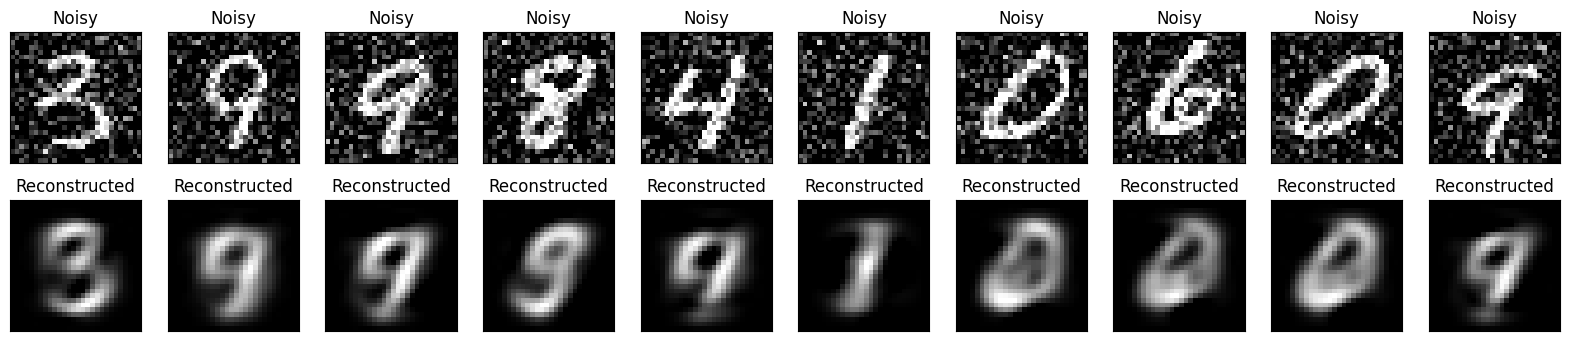

In [ ]:
noisy_x_test = torch.tensor(noisy_test_dataset.noisy_data).to(device)
encoded_imgs4 = denoising_autoencoder.encode(noisy_x_test.float())
decoded_imgs4 = denoising_autoencoder.decode(encoded_imgs4).cpu().detach().numpy()

# Display the original and encoded images
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title('Noisy')
    plt.imshow(noisy_x_test[i].reshape(28, 28).cpu())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title('Reconstructed')
    clipped = np.clip( decoded_imgs4[i].reshape(28, 28), 0., 1.)
    plt.imshow(clipped)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising with the DeepAutoEncoder

In [ ]:
# NOTE: Rerun this block if you want to use DeepAutoEncoder
#       again after using the SimpleAutoEncoder

# Set compress size
compress = 200

# Set representation size
representation_size = 32

# Train a DeepAutoEncoder for denoising.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
denoising_autoencoder = DeepAutoEncoder(compress, representation_size).to(device)

optimizer = torch.optim.Adam(denoising_autoencoder.parameters())
epochs = 50

# Train your autoencoder
for epoch in range(1, epochs+1):
    train_loss = train_denoiser(denoising_autoencoder, device, noisy_train_loader, optimizer)
    val_loss = test_denoiser(denoising_autoencoder, device, noisy_val_loader, )
    print('Train Epoch: {:02d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

# Test your autoencoder
print('Test Loss:', test_denoiser(denoising_autoencoder, device, noisy_test_loader))

Train Epoch: 01 	Training Loss: 0.045794 	Validation Loss: 0.031072
Train Epoch: 02 	Training Loss: 0.028558 	Validation Loss: 0.027284
Train Epoch: 03 	Training Loss: 0.026317 	Validation Loss: 0.025905
Train Epoch: 04 	Training Loss: 0.025178 	Validation Loss: 0.024943
Train Epoch: 05 	Training Loss: 0.024368 	Validation Loss: 0.024214
Train Epoch: 06 	Training Loss: 0.023734 	Validation Loss: 0.023632
Train Epoch: 07 	Training Loss: 0.023215 	Validation Loss: 0.023124
Train Epoch: 08 	Training Loss: 0.022769 	Validation Loss: 0.022682
Train Epoch: 09 	Training Loss: 0.022390 	Validation Loss: 0.022347
Train Epoch: 10 	Training Loss: 0.022069 	Validation Loss: 0.022073
Train Epoch: 11 	Training Loss: 0.021795 	Validation Loss: 0.021838
Train Epoch: 12 	Training Loss: 0.021551 	Validation Loss: 0.021654
Train Epoch: 13 	Training Loss: 0.021336 	Validation Loss: 0.021465
Train Epoch: 14 	Training Loss: 0.021141 	Validation Loss: 0.021306
Train Epoch: 15 	Training Loss: 0.020963 	Valida

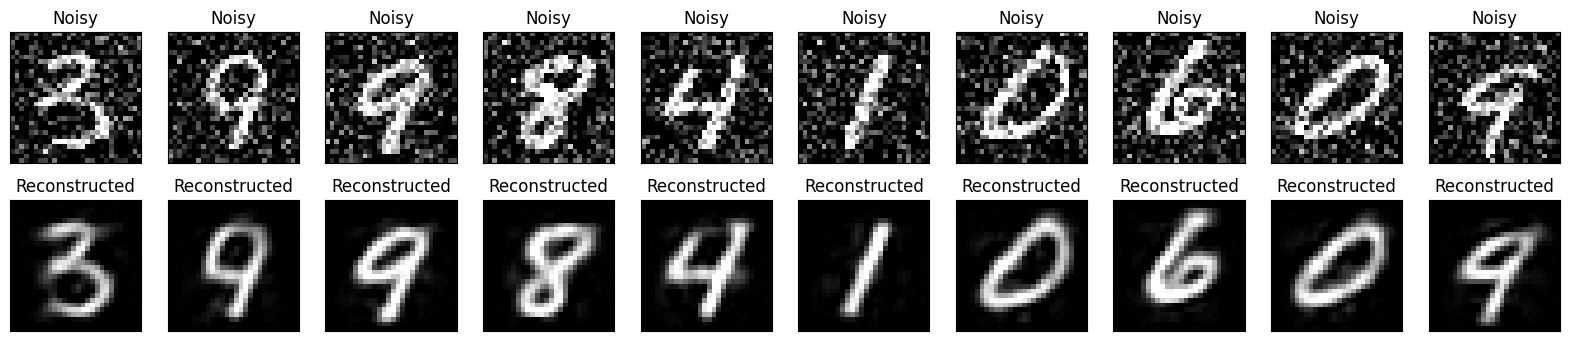

In [ ]:
noisy_x_test = torch.tensor(noisy_test_dataset.noisy_data).to(device)
encoded_imgs4 = denoising_autoencoder.encode(noisy_x_test.float())
decoded_imgs4 = denoising_autoencoder.decode(encoded_imgs4).cpu().detach().numpy()

# Display the original and encoded images
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title('Noisy')
    plt.imshow(noisy_x_test[i].reshape(28, 28).cpu())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title('Reconstructed')
    clipped = np.clip( decoded_imgs4[i].reshape(28, 28), 0., 1.)
    plt.imshow(clipped)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()